Open Anaconda, write<br>
<i>pip install lmfit</i>

# Lesson 4. Parameter Optimization

<b>Recommended preliminary knowledge:</b> Knowledge gained in lesson 3 and corresponding recommended preliminary knowledge. Furthermore, the user is encouraged to familiarize themselves with the Python package <i>lmfit</i>, which is useful for performing least-squared optimization.

Development of thermodynamic modelling functions: Xiaodong Liang<br>
Development of optimization functions: Daniel Qvistgaard<br>
Jupyter Notebook author: Daniel Qvistgaard

## 1. Introduction
In lesson 3 comparison functions were introduced. Comparison functions are helpful, because they return the deviation/error between the model and experimental data. In this chapter you will learn about parameter optimization using the CERE package, and at the heart of any parameter optimization is an <i>objective function</i>. Here the objective functions will contain the comparison functions we learned about in lesson 3.

## 2. Initialization
In order for any code blocks to properly work in this Jupyter Notebook, please run the following code block. This piece of code loads the CERE package containing thermodynamical functions. Furthermore, <i>Numpy</i> and <i>matplotlib</i> are loaded.

In [1]:
import pytherm #Required
#from scipy.optimize import leastsq

import numpy as np #Recommended
from matplotlib import pyplot as plt #Recommended - used for plotting
import pandas as pd #Recommended

## 3. New Classes
Thus far, two classes have been introduced: 
* Model - the heart of any thermodynamic calculations in this package
* comparisonFcn - the class responsible for performing comparison calculations

In this chapter two new classes will be introduced:
* Experimental_Data - A class dedicated to contain experimental data of any kind relevant to thermodynamic modelling.
* Optimizer - A class dedicated to running parameter optimization (for CPA specifically)

## 4. Experimental_Data
This class is dedicated to contain all the experimental data used in our parameter optimization

In [2]:
#Here we initialize the class
exp_data = pytherm.Experimental_Data()

#By using the "Add" class function, we may add experimental data to the class. First we add vapor pressure data
filename_psat = 'experimental_data/TEG_vapor_pressure.csv'
datatype_psat = 'PSat'
identifier_psat = 'teg_psat'
exp_data.Add(filename_psat, datatype_psat, identifier_psat)

#Similarly, we add liquid density data.
filename_rho = 'experimental_data/TEG_liq_density.csv'
datatype_rho = 'rho'
identifier_rho = 'teg_rho'
exp_data.Add(filename_rho, datatype_rho, identifier_rho)



In [3]:
#In this code section, we display the experimental data currently available in the class using the Show_list() function
print("Before adjusting for reduced temperature")
exp_data.Show_list()


Before adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              61x2            teg_rho        




In [4]:
#It is common to limit the pure component data to a specific temperature range, typically expressed as an
#an interval of reduced temperatures. If we seek to remove data outside these region, we impose the interval by 
#using the ReducedTemperature function

Tr_min = 0.4 #Reduced temperature min
Tr_max = 0.9 #Reduced temperature max
Tc = 769.5 #Critical temprature [K]
exp_data.ReducedTemperature(Tr_min, Tr_max, Tc)

print("After adjusting for reduced temperature")
exp_data.Show_list()

After adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              50x2            teg_rho        




By comparing the dimensions of the above two code sections, we see that 11 liquid density points have been removed by setting the reduced temperature interval.

We will now see how data can be retrieved from the class by using the <i>Retrieve_data</i> class function used to perform model predictions.

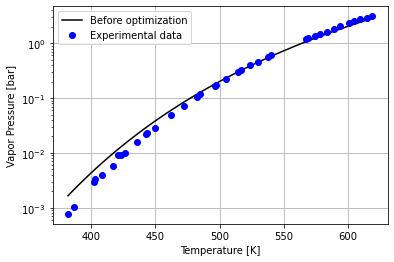

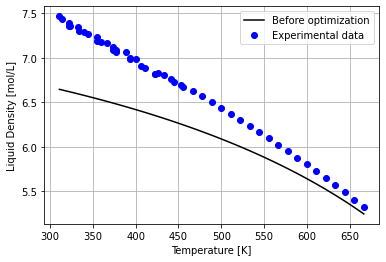

In [5]:
Thermo = pytherm.Model()

exp_psat = exp_data.Retrieve_data('teg_psat')
exp_rho = exp_data.Retrieve_data('teg_rho')

expT_psat = exp_psat[:,0]
expP = exp_psat[:,1]

expT_rho = exp_rho[:,0]
expRho = exp_rho[:,1]

n = 100 #Amount of linearly modelling points
T_model_psat = np.linspace(min(expT_psat),max(expT_psat),n)
T_model_rho = np.linspace(min(expT_rho),max(expT_rho),n)
P_model = np.zeros(n) #Memory allocation
rho_model = np.zeros(n) #Memory allocation

#Setting up thermodynamic calculations
Tc = 769.5
Pc = 33.2
Om = 0.05 
b0 = 138.93
Gamma = 3622.5
c1 = 0.9100

AssocEng =  1420.0
AssocVol = 20.0
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)


#Running calculations
Thermo.Setup_Thermo()

for i in range(0,n):
    P_model[i], b, c = Thermo.PBubble(T_model_psat[i],[1.0])
    rho_model[i] = Thermo.LiqRho(T_model_rho[i],[1.0])
    
Thermo.Finishup_Thermo()


#Plotting is made below
plt.plot(T_model_psat,P_model,color="black")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')
plt.legend(["Before optimization","Experimental data"])
plt.grid()
plt.show()
plt.plot(T_model_rho,rho_model,color="black")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Before optimization","Experimental data"])
plt.grid()
plt.show()




We can see from the above models that the model does not predict the data very well. In order to improve the model, it is necessary to optimize the parameters used. In the code block below a new object called Optimizer will be used.

In [10]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pytherm.Model()

Tc = 769.5
Pc = 33.2
Om = 0.05 #whatever

b0 = 128.93
Gamma = 3622.5
c1 = 0.9100

AssocEng =  1420.0
AssocVol = 20.0
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)

#From here we create a Optimizer object
optimizer = pytherm.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Calculation()

In [11]:
print(opti_params) 

{'b0': 127.84409439647777, 'Gamma': 3467.57499053812, 'c1': 0.999999999999995, 'AssocVol': 17.669970670122904, 'AssocEng': 1605.605228327573}


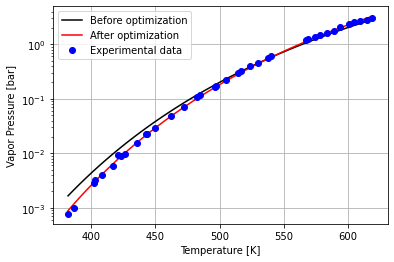

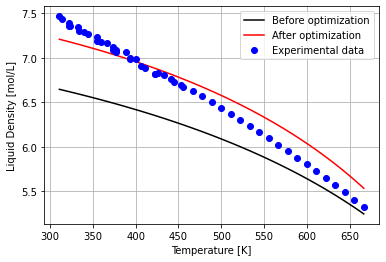

In [8]:
P_model_imp = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_imp = np.zeros(n) #Memory allocation - Good practice, more efficient


Thermo_improved = pytherm.Model() #Setting up thermodynamic calculations for the improved parameters.
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,Tc,Pc,Om)
Thermo_improved.CPAParams(1,opti_params["b0"],opti_params["Gamma"],opti_params["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params["AssocVol"],opti_params["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_imp[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_imp[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()
#-----------------------------------------------------------------------------------

plt.plot(T_model_psat,P_model,color="black")
plt.plot(T_model_psat,P_model_imp,color="red")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')

plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()

plt.plot(T_model_rho,rho_model,color="black")
plt.plot(T_model_rho,rho_model_imp,color="red")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()



We now see the results for performing parameter optimization.

***THIS SECTION IS UNDER CONSTRUCTION***

In [9]:
x = ([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf])

locations = {
    "b0" : 0,
    "Gamma" : 1,
    "c1" : 2,
    "AssocVol" : 3,
    "AssocEng" : 4
}

bounds = {
    "b0" : [-1, 1],
    "c1" : [0, 2]
}

for key, value in bounds.items():
    x[0][locations[key]] = value[0]
    x[1][locations[key]] = value[1]
    
print(x)

([-1, -inf, 0, -inf, -inf], [1, inf, 2, inf, inf])
